In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
np.random.seed(42) # Uczyńmy wyniki notatnika stabilnymi w poszczególnych przebiegach

#Zdefiniujmy domyślne rozmiary czcionek służące do generowania ładnych rysunków
plt.rc('font', size=12)
plt.rc('axes',labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)

#Zdefinujmy ustawienia biblioteki Pandas
pd.set_option('display.max_columns', None)

In [2]:
datapath = Path() / "data" / "lifesat" #Definiujemy ścieżkę do bieżącego katalogu
#Wczytuje zbiory
oecd_bli = pd.read_csv(datapath / "oecd_bli.csv")
gpd_per_capita = pd.read_csv(datapath / "gdp_per_capita.csv")
oecd_bli


,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,5.40,NaN,NaN
1,AUT,Austria,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.50,NaN,NaN
2,BEL,Belgium,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.70,NaN,NaN
3,CAN,Canada,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,6.00,NaN,NaN
4,CZE,Czech Republic,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,0.54,NaN,NaN
2365,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,NaN,NaN,32.09,NaN,NaN
2366,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,NaN,NaN,0.67,NaN,NaN
2367,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,WMN,Women,PC,Percentage,0,Units,NaN,NaN,19.37,NaN,NaN


In [3]:
gpd_per_capita


,Entity,Code,Year,"GDP per capita, PPP (constant 2017 international $)"
0,Afghanistan,AFG,2002,1189.784668
1,Afghanistan,AFG,2003,1235.810063
2,Afghanistan,AFG,2004,1200.278013
3,Afghanistan,AFG,2005,1286.793659
4,Afghanistan,AFG,2006,1315.789117
...,...,...,...,...
7104,Zimbabwe,ZWE,2016,3173.610829
7105,Zimbabwe,ZWE,2017,3274.611198
7106,Zimbabwe,ZWE,2018,3341.665418
7107,Zimbabwe,ZWE,2019,3027.656038


In [4]:
#Wstępnie przetwarzamy dane PKB per capita tak, żeby  był uwzględniany wyłącznie 2020 rok i uprośćmy nazwy kolumn
gpd_per_capita_2020 = gpd_per_capita[gpd_per_capita["Year"]==2020]
gpd_per_capita_2020 = gpd_per_capita_2020.rename(
    columns={
        "GDP per capita, PPP (constant 2017 international $)": "GDP per capita (USD)"
    }
)
gpd_per_capita_2020

,Entity,Code,Year,GDP per capita (USD)
18,Afghanistan,AFG,2020,1978.961579
49,Africa Eastern and Southern,NaN,2020,3387.594670
80,Africa Western and Central,NaN,2020,4003.158913
111,Albania,ALB,2020,13295.410885
142,Algeria,DZA,2020,10681.679297
...,...,...,...,...
6984,Vanuatu,VUT,2020,2762.791388
7015,Vietnam,VNM,2020,8200.331867
7046,World,OWID_WRL,2020,16194.040310
7077,Zambia,ZMB,2020,3270.035112


In [5]:
#Poszukiwane przez nas zadowolenie z życia
oecd_bli["Indicator"].value_counts()

Indicator
Student skills                                       200
Self-reported health                                 182
Quality of support network                           168
Life satisfaction                                    168
Labour market insecurity                             162
Homicide rate                                        123
Feeling safe walking alone at night                  123
Life expectancy                                      123
Water quality                                        123
Employment rate                                      123
Years in education                                   120
Educational attainment                               120
Long-term unemployment rate                          117
Employees working very long hours                    117
Time devoted to leisure and personal care             69
Air pollution                                         41
Voter turnout                                         41
Stakeholder engagemen

In [6]:
#Dlatego musimy utworzyć tabelę przestawną (pivot table)
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(
    index="Country",
    columns="Indicator",
    values="Value"
)
oecd_bli

Indicator,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,5.4,82.5,7.3,1.31,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,3.5,81.7,7.1,1.84,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,3.7,81.5,6.9,3.54,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,6.0,81.9,7.4,0.77,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3
Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,8.7,79.9,6.5,NaN,25879.0,85.0,1.2,57.0,1.3,443.0,NaN,47.0,71.0,17.5
Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,NaN,76.2,6.3,0.79,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1
Czech Republic,20.0,0.7,94.0,5.65,74.0,72.3,0.5,21453.0,NaN,24.0,3.1,79.1,6.7,1.04,25372.0,91.0,1.4,60.0,1.6,491.0,NaN,61.0,87.0,17.9
Denmark,9.0,0.5,81.0,2.34,74.0,83.5,0.6,29606.0,118637.0,23.0,4.2,80.9,7.6,1.31,51466.0,95.0,1.9,71.0,2.0,504.0,15.87,86.0,95.0,19.5


In [7]:
oecd_bli = oecd_bli.reset_index()
oecd_bli

Indicator,Country,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
0,Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,5.4,82.5,7.3,1.31,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
1,Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,3.5,81.7,7.1,1.84,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
2,Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,3.7,81.5,6.9,3.54,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
3,Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
4,Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,6.0,81.9,7.4,0.77,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3
5,Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,8.7,79.9,6.5,NaN,25879.0,85.0,1.2,57.0,1.3,443.0,NaN,47.0,71.0,17.5
6,Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,NaN,76.2,6.3,0.79,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1
7,Czech Republic,20.0,0.7,94.0,5.65,74.0,72.3,0.5,21453.0,NaN,24.0,3.1,79.1,6.7,1.04,25372.0,91.0,1.4,60.0,1.6,491.0,NaN,61.0,87.0,17.9
8,Denmark,9.0,0.5,81.0,2.34,74.0,83.5,0.6,29606.0,118637.0,23.0,4.2,80.9,7.6,1.31,51466.0,95.0,1.9,71.0,2.0,504.0,15.87,86.0,95.0,19.5
9,Estonia,8.0,7.0,89.0,2.42,74.0,69.0,3.1,19697.0,159373.0,17.0,3.8,77.8,5.7,1.92,24336.0,92.0,1.6,53.0,2.7,524.0,14.90,64.0,84.0,17.7


In [8]:
#Wyświetlamy podstawowe informacje o dataframe
gpd_per_capita_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 18 to 7108
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entity                224 non-null    object 
 1   Code                  179 non-null    object 
 2   Year                  224 non-null    int64  
 3   GDP per capita (USD)  224 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.8+ KB


In [9]:
full_country_stats = oecd_bli.merge(
    gpd_per_capita_2020,
    left_on="Country",
    right_on="Entity",
    how="inner"
)
full_country_stats

,Country,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Entity,Code,Year,GDP per capita (USD)
0,Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,5.4,82.5,7.3,1.31,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0,Australia,AUS,2020,48697.837028
1,Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,3.5,81.7,7.1,1.84,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0,Austria,AUT,2020,51935.603862
2,Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,3.7,81.5,6.9,3.54,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3,Belgium,BEL,2020,48210.033111
3,Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2,Brazil,BRA,2020,14063.982505
4,Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,6.0,81.9,7.4,0.77,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3,Canada,CAN,2020,45856.625626
5,Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,8.7,79.9,6.5,NaN,25879.0,85.0,1.2,57.0,1.3,443.0,NaN,47.0,71.0,17.5,Chile,CHL,2020,23324.524751
6,Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,NaN,76.2,6.3,0.79,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1,Colombia,COL,2020,13441.492952
7,Denmark,9.0,0.5,81.0,2.34,74.0,83.5,0.6,29606.0,118637.0,23.0,4.2,80.9,7.6,1.31,51466.0,95.0,1.9,71.0,2.0,504.0,15.87,86.0,95.0,19.5,Denmark,DNK,2020,55938.212809
8,Estonia,8.0,7.0,89.0,2.42,74.0,69.0,3.1,19697.0,159373.0,17.0,3.8,77.8,5.7,1.92,24336.0,92.0,1.6,53.0,2.7,524.0,14.90,64.0,84.0,17.7,Estonia,EST,2020,35638.421351
9,Finland,6.0,0.5,88.0,3.81,70.0,85.1,1.3,29943.0,200827.0,23.0,3.9,81.5,7.6,2.13,42964.0,95.0,1.9,70.0,2.2,523.0,15.17,67.0,95.0,19.8,Finland,FIN,2020,47260.800458


In [10]:
full_country_stats = full_country_stats[[
    "Country", "Life satisfaction", "GDP per capita (USD)"
]]
full_country_stats = full_country_stats.sort_values(
    by="GDP per capita (USD)"
)
full_country_stats

,Country,Life satisfaction,GDP per capita (USD)
29,South Africa,4.7,11466.189672
6,Colombia,6.3,13441.492952
3,Brazil,6.4,14063.982505
21,Mexico,6.5,17887.750736
5,Chile,6.5,23324.524751
27,Russia,5.8,26456.387938
12,Greece,5.4,27287.083401
33,Turkey,5.5,28384.987785
18,Latvia,5.9,29932.493910
13,Hungary,5.6,31007.768407


In [11]:
full_country_stats.to_csv(
    datapath/ "lifesat_full.csv",
    index=False
)

In [31]:
min_gdp = 23_500
max_gdp = 62_500

country_stats = full_country_stats[
    (full_country_stats["GDP per capita (USD)"] >= min_gdp)
    & (full_country_stats["GDP per capita (USD)"] <= max_gdp)
]
country_stats.to_csv(
    datapath / "lifesat.csv",
    index=False
)

In [13]:
lifesat = pd.read_csv("data/lifesat/lifesat.csv")
lifesat.rename(
    columns={"GDP per capita (USD)": "PKB na mieszkanca (USD)"},
    inplace=True
)
lifesat.rename(columns={"Life satisfaction": "Satysfakcja z zycia"},
               inplace=True)
lifesat

,Country,Satysfakcja z zycia,PKB na mieszkanca (USD)
0,Russia,5.8,26456.387938
1,Greece,5.4,27287.083401
2,Turkey,5.5,28384.987785
3,Latvia,5.9,29932.493910
4,Hungary,5.6,31007.768407
5,Portugal,5.4,32181.154537
6,Poland,6.1,32238.157259
7,Estonia,5.7,35638.421351
8,Spain,6.3,36215.447591
9,Slovenia,5.9,36547.738956


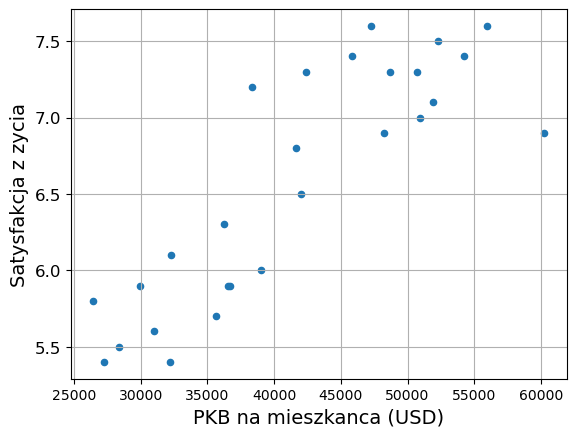

In [14]:
lifesat.plot(kind='scatter', grid=True,
             x="PKB na mieszkanca (USD)", y='Satysfakcja z zycia')
plt.show()

In [15]:
#przygotowuje zmienne w modelu
X = lifesat[["PKB na mieszkanca (USD)"]]
y = lifesat[["Satysfakcja z zycia"]]

#wybiera model liniowy
model = LinearRegression()

#trenujemy model
model.fit(X, y)

# obliczamy współczynniki modelu
theta_0=model.intercept_[0]
theta_1=model.coef_[0][0]
print(f"theta_0: {theta_0}")
print(f"theta_1: {theta_1}")

theta_0: 3.7490494273769093
theta_1: 6.778899694341222e-05


In [16]:
model.coef_

array([[6.77889969e-05]])

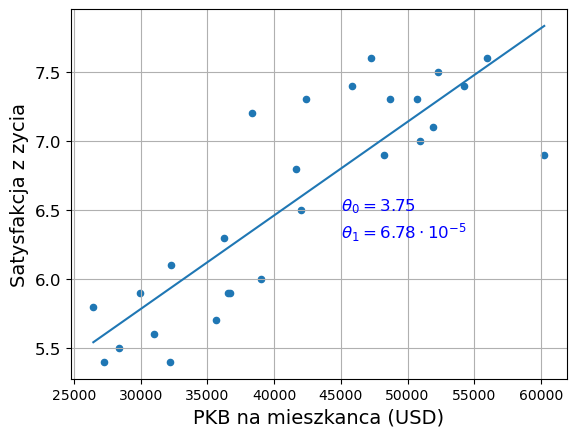

In [19]:
#Wizualizujemy dane
lifesat.plot(kind='scatter', grid=True,
             x="PKB na mieszkanca (USD)", y='Satysfakcja z zycia')
plt.plot(X, theta_0+theta_1*X)
plt.text(45000, 6.5, fr"$\theta_0 = {theta_0.round(2)}$",
         color="blue")
plt.text(45000, 6.3, fr"$\theta_1 = {theta_1 * 1e5: .2f}\cdot 10^{{-5}}$",
         color="blue")
plt.show()


In [20]:
cyprus_gdp_per_capita_2020 = (
    gpd_per_capita_2020[gpd_per_capita_2020["Entity"]=="Cyprus"][["GDP per capita (USD)"]]
)
cyprus_gdp_per_capita_2020.rename(
    columns={"GDP per capita (USD)": "PKB na mieszkanca (USD)"},
    inplace=True
)
cyprus_gdp_per_capita_2020

,PKB na mieszkanca (USD)
1517,37655.180346


In [21]:
cyprus_predicted_life_satisfaction = model.predict(cyprus_gdp_per_capita_2020)
cyprus_predicted_life_satisfaction

array([[6.30165633]])

In [22]:
#Wybiera model regresji 3-najbliższych sasiadów
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=3)

#Trenuje model_knn
model_knn.fit(X, y)

#Uzyskuje przewidywania dla Cypru
model_knn.predict(cyprus_gdp_per_capita_2020)

array([[6.33333333]])